**Proposed holiday**: 2019-08-05 to 2019-08-12

In [10]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd

In [12]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [14]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [16]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [19]:
inspector = inspect(engine)
inspector.get_table_names()
inspector.get_columns('station')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).first()
cutoff_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d') - dt.timedelta(365, 0, 0)
print(f'Cutoff Date: {cutoff_date}')

# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= cutoff_date)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data = pd.read_sql(prcp_query.statement, session.bind)

# Sort the dataframe by date
prcp_data = prcp_data.sort_values('date', ascending=True).reset_index(drop=True)
prcp_data = prcp_data.set_index('date')

Cutoff Date: 2016-08-23 00:00:00


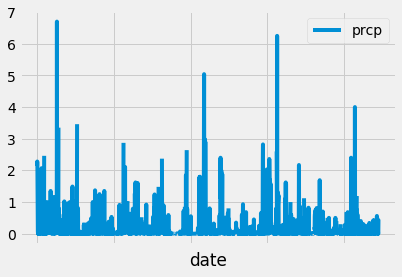

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_data.plot()

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
# Design a query to show how many stations are available in this dataset?
station_query = session.query(Station.id)
station_data = pd.read_sql(station_query.statement, session.bind)
len(station_data)

9

In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_query = session.query(Measurement.station, Measurement.id)
station_data = pd.read_sql(station_query.statement, session.bind)
station_data.groupby('station').count().sort_values('id', ascending=False)['id']

station
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: id, dtype: int64

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_query = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station=='USC00519281')
temp_data = pd.read_sql(temp_query.statement, session.bind)
[temp_data['tobs'].min(), temp_data['tobs'].max(), temp_data['tobs'].mean()]

[54.0, 85.0, 71.66378066378067]

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_query = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.date >= cutoff_date).filter(Measurement.station=='USC00519281')
temp_data = pd.read_sql(temp_query.statement, session.bind)

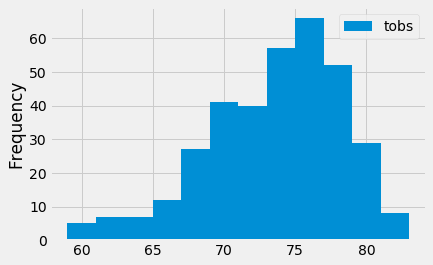

In [27]:
plt.hist(temp_data['tobs'], bins=12)
plt.ylabel('Frequency')
plt.legend(['tobs'])

![precipitation](Images/station-histogram.png)

## Optional: Other Recommended Analyses


In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


#Holiday dates: 2019-08-05 to 2019-08-12
temp_summary = calc_temps('2017-08-05', '2017-08-12')
temp_summary

[(71.0, 79.36666666666666, 83.0)]

[]

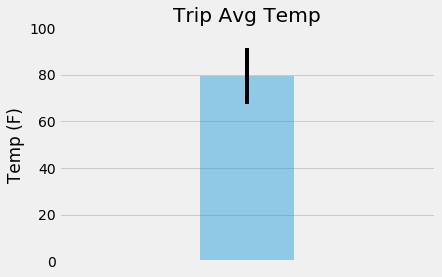

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
t_avg = temp_summary[0][1]
t_min = temp_summary[0][0]
t_max = temp_summary[0][2]
plt.bar(0, t_avg, width=0.5, yerr=(t_max-t_min), alpha=0.4)
plt.xlim(-1, 1)
plt.ylim(0, 100)
plt.xticks([])
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.plot()

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prcp_query = session.query(Measurement.date, Measurement.prcp, Measurement.station)\
    .filter(Measurement.date >= '2017-08-05')\
    .filter(Measurement.date <= '2017-08-12')    
prcp_df = pd.read_sql(prcp_query.statement, session.bind)
station_df = pd.read_sql(session.query(Station).statement, session.bind)

prcp_station_df = prcp_df.groupby('station').sum().reset_index().merge(station_df, on='station').sort_values('prcp', ascending=False)
prcp_station_df

,station,prcp,id,name,latitude,longitude,elevation
1,USC00516128,0.75,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
0,USC00514830,0.10,3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00519281,0.06,7,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00519397,0.00,1,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,USC00519523,0.00,6,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


## Optional Challenge Assignment

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [40]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

#Holiday dates: 2019-08-05 to 2019-08-12

vacation_days = []
for x in range(5, 13):
    if x >= 10:
        vacation_days.append(f'08-{x}')
    else:
        vacation_days.append(f'08-0{x}')

vacation_days

# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []
for day in vacation_days:
    normals.append(daily_normals(day)[0])

In [44]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normals, columns = ['tmin', 'tavg', 'tmax'])
normal_df['date'] = [f'2018-{day}' for day in vacation_days]
normal_df = normal_df.set_index('date')
normal_df

,tmin,tavg,tmax
date,,,
2018-08-05,69.0,76.148148,82.0
2018-08-06,67.0,76.250000,83.0
2018-08-07,71.0,77.156863,83.0
2018-08-08,68.0,76.557692,83.0
2018-08-09,69.0,75.980392,81.0
2018-08-10,65.0,76.420000,83.0
2018-08-11,67.0,75.981132,82.0
2018-08-12,67.0,76.527273,83.0


Text(0, 0.5, 'Temperature (F)')

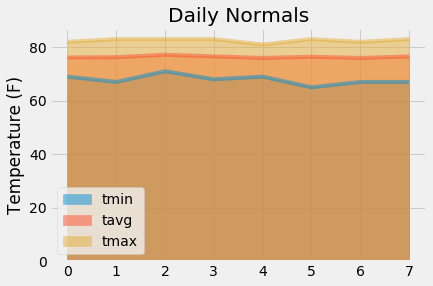

In [74]:
# Plot the daily normals as an area plot with `stacked=False`
fig1 = normal_df.plot(kind='area', stacked=False)
fig1.set_title('Daily Normals')
fig1.set_ylabel('Temperature (F)')